<h3> The Notebook computes the PNA index using definition of Wallace and Gutzler (1981)</h3> 
https://doi.org/10.1175/1520-0493(1981)109<0784:TITGHF>2.0.CO;2 >

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from src.datareader import datareader as dr

<h3>Initialize Data Readers</h3>

In [2]:
# ufs_data_reader = dr.getDataReader(datasource='UFS', filename="experiments/phase_1/baseline/atm_monthly.zarr", model='atm')
# era5_data_reader = dr.getDataReader(datasource='ERA5', filename="1959-2022-6h-1440x721.zarr/") # <-- 6hr, high resolution data

ufs_data_reader = dr.getDataReader(datasource='UFS', filename="experiments/phase_1/baseline/atm_monthly.zarr", model='atm')
era5_data_reader = dr.getDataReader(datasource='ERA5') # <-- 6hr, lower-resolution data by default

Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/baseline/atm_monthly.zarr
UFS dataset loaded.
Standardizing coordinate system
Dataset ready.
No filename provided; deferring to default
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr/
ERA5 dataset loaded.
Standardizing coordinate system
Sorting lat descending
Dataset ready.


In [ ]:
# ufs_data_reader.describe()

In [ ]:
# era5_data_reader.describe()

<h3>Retrieve DataSets</h3>

In [3]:
time_range = ("1994-05-01","2021-05-31T23")

In [4]:
# Retrieve a UFS dataset
# The complete dataset is preserved after retrieval
ufs_ds = ufs_data_reader.retrieve(
    var = 'phi',
    lev = 500,
    time=time_range,
    ens_avg=True
) 

Slicing by init
Slicing by model dimension lev
Taking Ensemble Average


In [ ]:
# ufs_ds.phi

In [5]:
# Retrieve an ERA5 dataset 
# The complete dataset is preserved after retrieval
era5_ds = era5_data_reader.retrieve(
    var='geopotential',
    lev = 500,
    time=time_range
)

Slicing by time
Slicing by lev


<h3>Calculate PNA Index for UFS and ERA5</h3>
UFS contains geopotential height [gpm] whereas ERA5 geopotential [m^2/s^2]. Geopotential will be converted to geopotential height.  

In [6]:
from climpred import HindcastEnsemble
import climpred

In [7]:
fcstpna = 0.25*(ufs_ds['phi'].sel(lat = 20,lon = 200, method = 'nearest')-
              ufs_ds['phi'].sel(lat = 45,lon = 195, method = 'nearest')+
              ufs_ds['phi'].sel(lat = 55,lon = 245, method = 'nearest')-
              ufs_ds['phi'].sel(lat = 30,lon = 275, method = 'nearest'))
verifpna = 0.25*(era5_ds['geopotential'].sel(lat = 20,lon = 200, method = 'nearest')-
                 era5_ds['geopotential'].sel(lat = 45,lon = 195, method = 'nearest')+
                 era5_ds['geopotential'].sel(lat = 55,lon = 245, method = 'nearest')-
                 era5_ds['geopotential'].sel(lat = 30,lon = 275, method = 'nearest'))/9.8 

<h3> Resample ERA5 to monthly means</h3>

In [8]:
verifpna=verifpna.resample(time='MS').mean()

<h3>Calculate anomalies and normalize them</h3>
Normalization is the standard deviation from each month (to be implemented)

In [9]:
fcst = HindcastEnsemble(fcstpna.load())
fcst = fcst.add_observations(verifpna.load().rename('phi'))
fcst = fcst.remove_seasonality("month")

<h3>Calculate anomaly correlation and plot it</h3>

In [10]:
result_acc = fcst.verify(metric='acc',comparison='e2o',dim='init',alignment='maximize',groupby='month')

In [11]:
skill_acc = np.empty([len(result_acc.lead), 12])
skill_acc.fill(np.nan)
skill_acc[:,4] = result_acc['phi'][0,:]
skill_acc[:,11] = result_acc['phi'][1,:]

Text(0, 0.5, 'Lead Time (Months)')

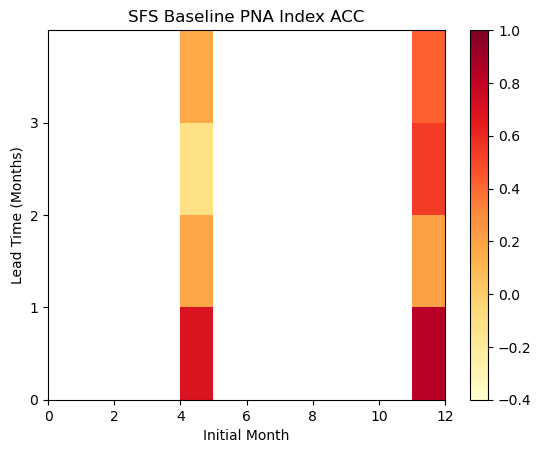

In [13]:
fig,ax = plt.subplots()
pcm = ax.pcolormesh(skill_acc,cmap=plt.cm.YlOrRd,vmin=-0.4,vmax=1.0)
fig.colorbar(pcm,ax = ax)
ax.set_yticks(np.arange(len(result_acc.lead)))
plt.title("SFS Baseline PNA Index ACC")
plt.xlabel("Initial Month")
plt.ylabel("Lead Time (Months)")

Text(0, 0.5, 'ACC')

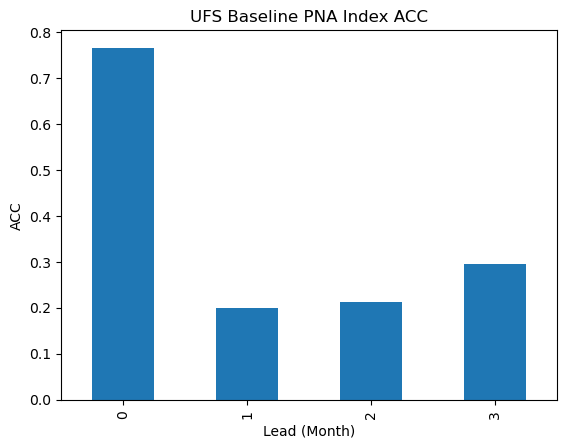

In [15]:
result_acc.phi.mean(dim='month').to_series().plot(kind="bar")
plt.title("UFS Baseline PNA Index ACC")
plt.xlabel("Lead (Month)")
plt.ylabel("ACC")

<h3>Compare with CPC ICs</h3>

In [16]:
# clean up data no longer neede
del ufs_data_reader, ufs_ds, fcst, fcstpna

<h3>Retrieve DataSets</h3>

In [17]:
ufs_data_reader = dr.getDataReader(datasource='UFS', filename='experiments/phase_1/cpc_ics/atm_monthly.zarr',model='atm')

Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/cpc_ics/atm_monthly.zarr
UFS dataset loaded.
Standardizing coordinate system
Dataset ready.


In [18]:
ufs_ds = ufs_data_reader.retrieve(
    var = 'phi',
    time=time_range,
    lev=500,
    ens_avg=True
) 

Slicing by init
Slicing by model dimension lev
Taking Ensemble Average


<h3>Calculate PNA Index</h3> 

In [19]:
fcstpna = 0.25*(ufs_ds['phi'].sel(lat = 20,lon = 200, method = 'nearest')-
              ufs_ds['phi'].sel(lat = 45,lon = 195, method = 'nearest')+
              ufs_ds['phi'].sel(lat = 55,lon = 245, method = 'nearest')-
              ufs_ds['phi'].sel(lat = 30,lon = 275, method = 'nearest'))

<h3>Calculate anomalies and normalize them</h3>
Normalization is the standard deviation from each month (to be implemented)

In [20]:
fcst_cpc = HindcastEnsemble(fcstpna.load())
fcst_cpc = fcst_cpc.add_observations(verifpna.load().rename('phi'))
fcst_cpc = fcst_cpc.remove_seasonality("month")

<h3>Calculate anomaly correlation and plot it</h3>

In [21]:
result_cpc_acc = fcst_cpc.verify(metric='acc',comparison='e2o',dim='init',alignment='maximize',groupby='month')

In [22]:
skill_cpc_acc = np.empty([12, 12])
skill_cpc_acc.fill(np.nan)
skill_cpc_acc[:,4] = result_cpc_acc['phi'][0,:]
skill_cpc_acc[:,11] = result_cpc_acc['phi'][1,:]

Text(0, 0.5, 'Lead Time (Months)')

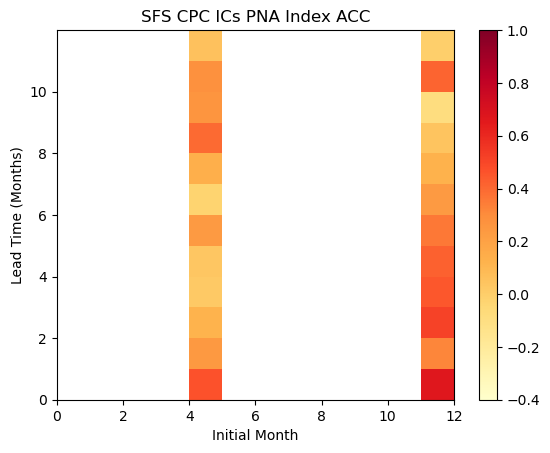

In [23]:
fig,ax = plt.subplots()
pcm = ax.pcolormesh(skill_cpc_acc,cmap=plt.cm.YlOrRd,vmin=-0.4,vmax=1.0)
fig.colorbar(pcm,ax = ax)
ax.set_yticks(np.arange(0,12,2))
plt.title("SFS CPC ICs PNA Index ACC")
plt.xlabel("Initial Month")
plt.ylabel("Lead Time (Months)")

Text(0, 0.5, 'ACC')

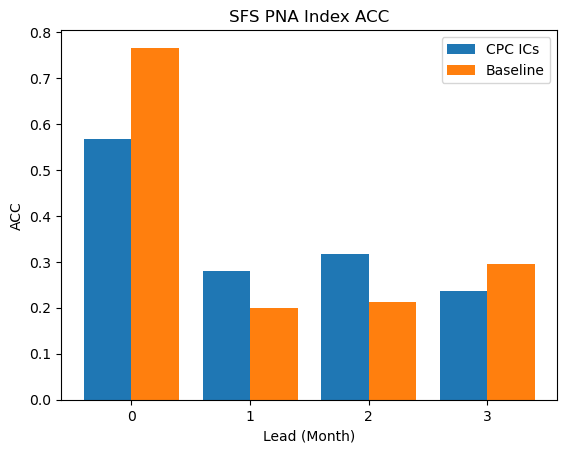

In [24]:
w,x = 0.4,np.arange(len(result_acc.lead))
fig, ax = plt.subplots()
ax.bar(x-w/2,result_cpc_acc.phi[:,0:4].mean(dim='month').to_series(),width=w,label='CPC ICs')
ax.bar(x+w/2,result_acc.phi.mean(dim='month').to_series(),width=w,label='Baseline')
ax.set_xticks(np.arange(len(result_acc.lead)))
ax.legend()
plt.title("SFS PNA Index ACC")
plt.xlabel("Lead (Month)")
plt.ylabel("ACC")